In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os
sys.path.append('/Users/roz18/git/Python/user_modules')
from readEazyBinary import readpz
from scipy import interpolate
from scipy import stats
import skgof

In [5]:
path = '/Users/roz18/Dropbox/Work/mini-projects/Buzzard-EAZY/inputs_Buzzard_training/OUTPUT'

cat = Table.read('/Users/roz18/Documents/Data/mini-projects/buzzard_photo-z/Final_Buzzard_training_file.fits')
print(len(cat))
cat_id = np.arange(len(cat))

# Gold sample cut
mask = cat['LSSTi']<25.3
print(np.sum(mask))

# Remove objects with invalide flux measurements
mask = mask & (cat['LSSTu']!=99.) & (cat['LSSTg']!=99.) & (cat['LSSTr']!=99.) & \
       (cat['LSSTi']!=99.) & (cat['LSSTz']!=99.) & (cat['LSSTy']!=99.)
print(np.sum(mask))

# redshift range
zmin = 0.
zmax = 2.0
mask = mask & (cat['redshift']>zmin) & (cat['redshift']<zmax)
print(np.sum(mask))
cat_id = cat_id[mask]

# Random downsampling
nsamp = 10000
np.random.seed(61723)
cat_id = np.random.choice(cat_id, size=nsamp, replace=False)

cat = cat[cat_id]
print(len(cat))

z_spec = cat['redshift']

111171
44410
43486
43486
10000


In [6]:
# Load p(z) data
pz_dict = readpz(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY=path, APPLY_PRIOR=False)
# Redshift grid
zgrid = pz_dict['zgrid']
# p(z)
pz = pz_dict['pz'][cat_id]
# prior = pz_dict['prior'][cat_id]
# chi squared
chi2 = pz_dict['chi2'][cat_id]

In [7]:
# Interpolate between the grid points.
# set the number of iterations
n_iterations = 3
zgrid_fine = zgrid.copy()
for index in range(n_iterations):
    zgrid1 = np.zeros(len(zgrid_fine)*2-1)
    zgrid1[::2] = zgrid_fine
    zgrid1[1::2] = (zgrid_fine[:-1]+zgrid_fine[1:])/2
    zgrid_fine = zgrid1.copy()
    
pz_fine = np.zeros((len(pz), len(zgrid_fine)))
for index in range(len(pz)):
    pz_interp = interpolate.interp1d(zgrid, pz[index], kind='linear')
    pz_fine[index] = pz_interp(zgrid_fine)
    print('\r{}'.format(index+1), end='')

10000

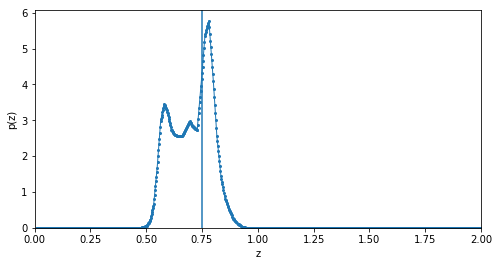

In [8]:
idx = 934
plt.figure(figsize=(8, 4))
plt.plot(zgrid_fine, pz_fine[idx], '.-', markersize=4, lw=1)
# plt.plot(zgrid, prior[idx])
plt.axvline(z_spec[idx])
plt.xlim(0, 2.)
plt.ylim(ymin=0)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

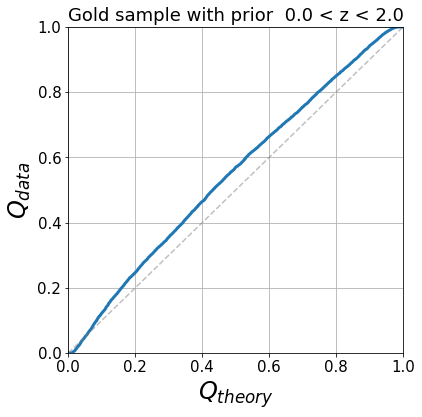

In [9]:
zgrid1 = np.ones((len(pz_fine), len(zgrid_fine)))*zgrid_fine
t = np.array(zgrid1< z_spec[:, None], dtype=float)
# set p(z) to zero for z>z_spec
pz1 = pz_fine * t
# Integrate to get CDF values at z_spec
cdfs = np.trapz(pz1, zgrid_fine, axis=1)
# Sort CDF values to get quantiles
q_data = np.sort(cdfs)
q_theory = np.linspace(0.5/len(q_data), 1-0.5/len(q_data), len(q_data))

x = np.linspace(0, 1)
plt.figure(figsize=(6,6))
plt.plot(q_theory, q_data, linewidth=3)
plt.plot(x, x, '--', color='grey', alpha=0.5)
plt.title('Gold sample with prior  {} < z < {}'.format(zmin, zmax), fontsize=18)
plt.xlabel(r'$Q_{theory}$', fontsize=24)
plt.ylabel(r'$Q_{data}$', fontsize=24)
plt.tick_params(labelsize=15)
plt.axis([0, 1., 0, 1.])
plt.grid()
plt.show()

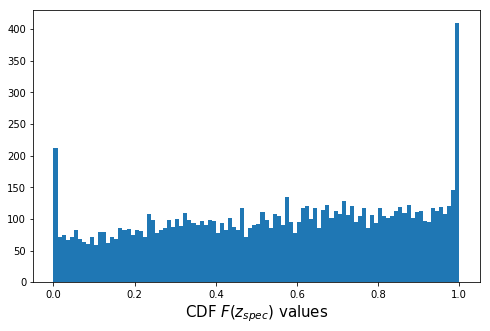

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(cdfs, 100)
plt.xlabel(r'CDF $F(z_{spec})$ values', fontsize=15)
plt.show()

-------
## Metrics

In [11]:
# Kolmogorov-Smirnov
skgof.ks_test(cdfs, stats.uniform())

GofResult(statistic=0.070096696205732834, pvalue=3.6008556428701244e-43)

In [12]:
# Cramer-von Mises
skgof.cvm_test(cdfs, stats.uniform())

GofResult(statistic=26.248746339656453, pvalue=2.9995070124355649e-06)

In [13]:
# CvM-like distance
skgof.cvm_test(cdfs, stats.uniform()).statistic/len(cdfs)

0.0026248746339656453

In [14]:
# Anderson-Darling
skgof.ad_test(cdfs, stats.uniform())

/Users/roz18/anaconda/lib/python2.7/site-packages/skgof/ecdfgof.py:81: RuntimeWarning: divide by zero encountered in log
  return -samples - (factors * log(data * (1 - data[::-1]))).sum() / samples


GofResult(statistic=inf, pvalue=0.0)

__CDF values of 1.0 cause the AD statistic to diverge. Slightly modify the maximum CDF value to fix this divergence. __

In [15]:
# Correct for numerical error that causes cdfs
# to be larger than 1.
eps = 1e-16
mask = cdfs>(1-eps)
cdfs1  = cdfs.copy()
cdfs1[mask] = 1-eps

#############
mask = (cdfs>0) & (cdfs<1)
cdfs1 = cdfs[mask]
#############

# Anderson-Darling
skgof.ad_test(cdfs1, stats.uniform())

GofResult(statistic=183.10373517358676, pvalue=6.0072086527362956e-08)

In [16]:
# AD-like distance
skgof.ad_test(cdfs1, stats.uniform()).statistic/len(cdfs)

0.018310373517358675

In [17]:
ad = []
for i in range(7, 17):
    eps = 10**(-i)
    mask = cdfs>(1-eps)
    cdfs1  = cdfs.copy()
    cdfs1[mask] = 1-eps
    ad.append(skgof.ad_test(cdfs1, stats.uniform()).statistic)

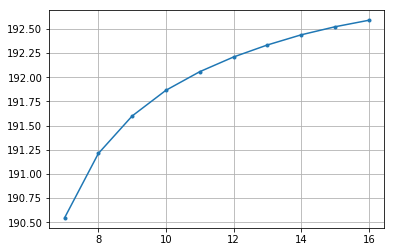

In [18]:
plt.plot(range(7, 17), ad, '.-')
plt.grid()
plt.show()

__The AD statistic does not converge with the smallest possible eps of 1e-15. __

In [19]:
def compute_cdf(a, bins):
    """
    Inputs
    ------
    a: 1-D array of elements;
    bins: bins for the CDF;

    Outputs
    -------
    cdf: 1-D array of CDF values in each bin; 
    binedges: edges of the bins;
    binctr: center of the bins;
    """
    hist, binedges = np.histogram(a, bins=bins)
    hist = hist/len(a)
    binctr = (binedges[1:] + binedges[:-1])/2.
    cdf = np.zeros(len(hist))
    cdf[0] = hist[0]
    for cdf_index in range(1, len(hist)):
        cdf[cdf_index] = cdf[cdf_index-1]+hist[cdf_index]
        
    return cdf, binedges, binctr

def ad_approx(n, x, y, yt):
    '''
    Calculate approximate Anderson-Darling statistic using ECDF;
    n: sample size;
    x: array of the grid; 
    y: array of gridded CDF values of the sample;
    yt: array of gridded CDF values of theoretical distribution;
    '''
    # compute Anderson-Darling statistic
    inv_weight = (yt*(1-yt))[:-1]
    # remove infinities in the weight function
    mask = (inv_weight<1e-5)
    inv_weight[mask] = 1
    ads = n * np.sum(((y - yt)[:-1])**2*(yt[1:]-yt[:-1])/inv_weight)
    return ads


def ad_approx_plot(n, x, y, yt):
    # compute Anderson-Darling statistic
    inv_weight = (yt*(1-yt))[:-1]
    # remove infinities in the weight function
    mask = (inv_weight<1e-5)
    inv_weight[mask] = 1
    plt.figure(figsize=(8, 6))
    plt.plot(yt[:-1], ((y - yt)[:-1])**2*(yt[1:]-yt[:-1])/inv_weight)
    plt.grid()
    plt.show()

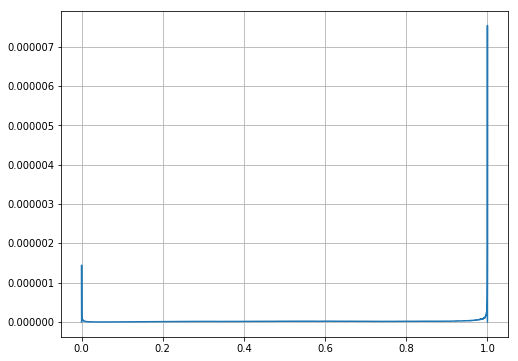

In [20]:
# Correct for numerical error that causes cdfs
# to be larger than 1.
eps = 1e-16
mask = cdfs>(1-eps)
cdfs1  = cdfs.copy()
cdfs1[mask] = 1-eps

#############
mask = (cdfs>0.) & (cdfs<1)
cdfs1 = cdfs[mask]
#############

n = 100
bins = np.linspace(0, 1., int(1e6))
cdf, _, binctr = compute_cdf(cdfs1, bins=bins)

rv = stats.uniform()
cdf_theory = rv.cdf(binctr)

ad_approx(n, binctr, cdf, cdf_theory)
ad_approx_plot(n, binctr, cdf, cdf_theory)